In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
import matplotlib.pyplot as plt
import time
from src.prawscrape import prawpull as pwp

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
%matplotlib inline 

In [6]:
#support functions 
#Solution comes from: https://stackoverflow.com/questions/34122395/reading-a-csv-with-a-timestamp-column-with-pandas
def date_parser(string_list):
    return [time.ctime(float(x)) for x in string_list]



In [7]:
acroDF = pd.read_csv("./data/datatable.csv", header=None,parse_dates=[1],date_parser=date_parser,
                     names=["commID","time","user","subreddit","acronym"])

In [20]:
acroDF.head(5)

,commID,time,user,subreddit,acronym
0,eppv9ry,2019-06-01 08:38:08,arXiv_abstract_bot,MachineLearning,PDF
1,eppqbve,2019-06-01 07:29:08,arXiv_abstract_bot,MachineLearning,KDDC
2,eppsbtw,2019-06-01 07:59:01,tuseroni,MachineLearning,LOOK
3,eppzy33,2019-06-01 09:36:41,farmingvillein,MachineLearning,GPT
4,eppu90m,2019-06-01 08:25:04,tuseroni,MachineLearning,CSS


Lets look at some basic info, and scan for nas/anomolies:

In [113]:
acroDF.shape
acroDF.count() #There are some NA acronyms.
acroDF.dropna(inplace=True)
acroDF.count() #Now every row is fully defined. 



(142965, 5)

commID       142965
time         142965
user         142965
subreddit    142965
acronym      142965
dtype: int64

commID       142965
time         142965
user         142965
subreddit    142965
acronym      142965
dtype: int64

In [122]:
#There are some NA acronyms.
type(acroDF.iloc[[1],[1]])


pandas.core.frame.DataFrame

How many acronyms are there per subreddit? There are a few factors that can affect this: The sr topic or field itself, the number of users, etc. Getting the number of users per subreddit, might give an estimate

In [69]:
#By default, the grouping column will turn into a named index. It will no longer be a column you can access!
#use the as_index=False option to make it a column in the final data frame.
srGroups = acroDF.groupby(by="subreddit",as_index=False).count()
srGroups.shape
srGroups

(55, 5)

,subreddit,commID,time,user,acronym
0,AstroPhysics,710,710,710,710
1,Astronomy,913,913,913,913
2,Bio_Hacking,67,67,67,67
3,Biochemistry,1646,1646,1646,1646
4,Biology,957,957,957,957
5,Bitcoin,2269,2269,2269,2269
6,BitcoinMarkets,30297,30297,30297,30297
7,ChemicalEngineering,1906,1906,1906,1906
8,Chemistry,1225,1225,1225,1225
9,CryptoCurrency,4778,4778,4778,4778


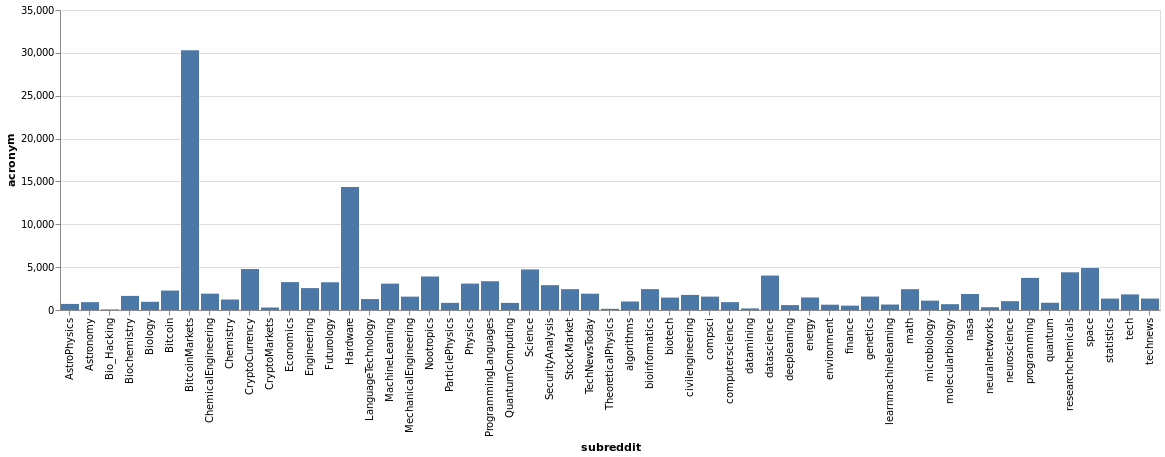

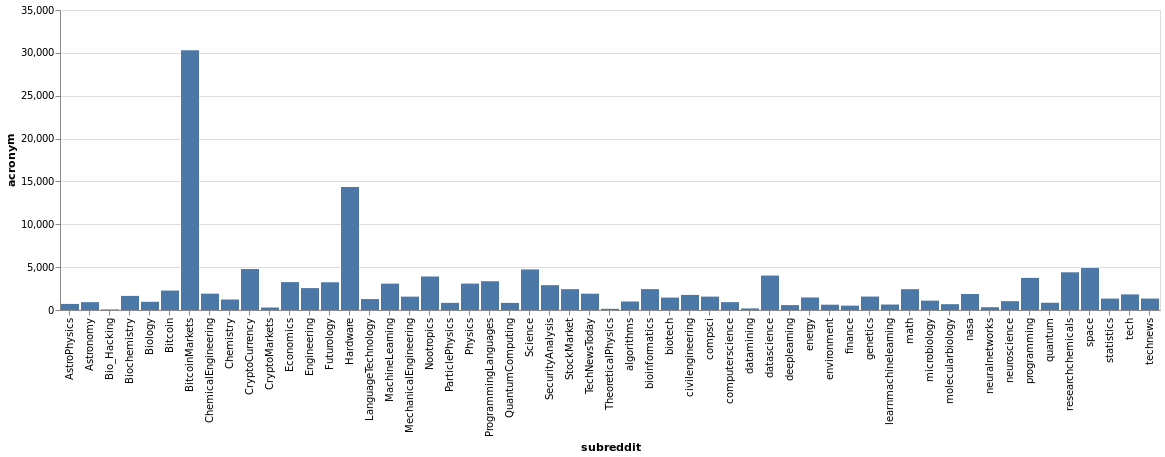

In [51]:
#Lets make our altair histogram for this.
alt.Chart(srGroups).mark_bar().encode(
x='subreddit',
y='acronym')

We can see that a few subreddits really like using acronyms (Hardware, BitcoinMarkets). It would be useful to know the size of the subreddits. Getting total number of submissions/comments is hard, as you can only access submissions through search, or via ListingGenerators. 

I would have to exhaust LGs with very high limits, to get the number of submissions. From the subreddit object itself, we can get number of users and date that subreddit was created (as a kind of proxy measure).

In [61]:
#lets get our subreddit support dataframe.

#initialize our reddit connection:
sr = pwp.startredditsession("/home/user/Documents/Workspace/Me/Credentials/reddit.txt", True)
srDF = pd.read_csv("./data/subreddits.txt",names=["subreddit"])
srList = srDF['subreddit'].to_list()
subscribeList = []
utcList = []
for item in srList:
    subscribeList.append(sr.subreddit(item).subscribers)
    utcList.append(sr.subreddit(item).created_utc)
    

In [70]:
srDF["subscribers"] = pd.Series(subscribeList)
srDF["utc_created"] = pd.Series(date_parser(utcList))
srDF["acroCount"] = srGroups["acronym"]
srDF


,subreddit,subscribers,utc_created,acroCount,acroRatio
0,MachineLearning,674122,Wed Jul 29 10:34:44 2009,710.0,0.001053
1,learnmachinelearning,70763,Tue Feb 23 02:37:54 2016,913.0,0.012902
2,datascience,122921,Sat Aug 6 07:43:42 2011,67.0,0.000545
3,deeplearning,33300,Sun Nov 27 11:42:01 2011,1646.0,0.049429
4,neuralnetworks,10221,Mon Dec 30 22:51:05 2013,957.0,0.093631
5,LanguageTechnology,15497,Wed Mar 10 11:42:30 2010,2269.0,0.146415
6,Physics,770826,Sun Mar 16 02:04:52 2008,30297.0,0.039305
7,TheoreticalPhysics,3408,Sat Jul 7 02:56:42 2012,1906.0,0.559272
8,AstroPhysics,15658,Fri Jan 15 19:34:12 2010,1225.0,0.078235
9,ParticlePhysics,12287,Thu Aug 6 07:39:08 2009,4778.0,0.388866


,subreddit,subscribers,utc_created,acroCount,acroRatio
0,MachineLearning,674122,Wed Jul 29 10:34:44 2009,710.0,0.001053
1,learnmachinelearning,70763,Tue Feb 23 02:37:54 2016,913.0,0.012902
2,datascience,122921,Sat Aug 6 07:43:42 2011,67.0,0.000545
3,deeplearning,33300,Sun Nov 27 11:42:01 2011,1646.0,0.049429
4,neuralnetworks,10221,Mon Dec 30 22:51:05 2013,957.0,0.093631


Median=70763.0


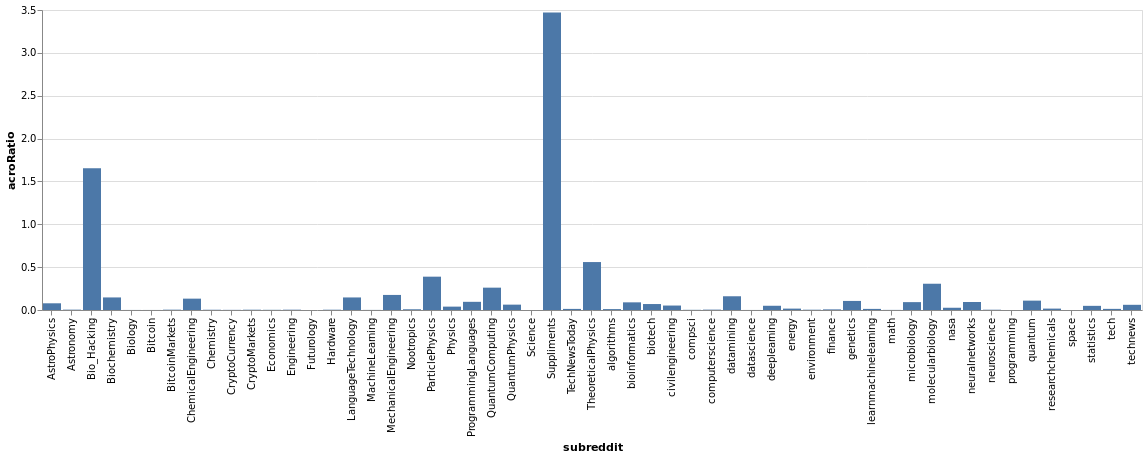

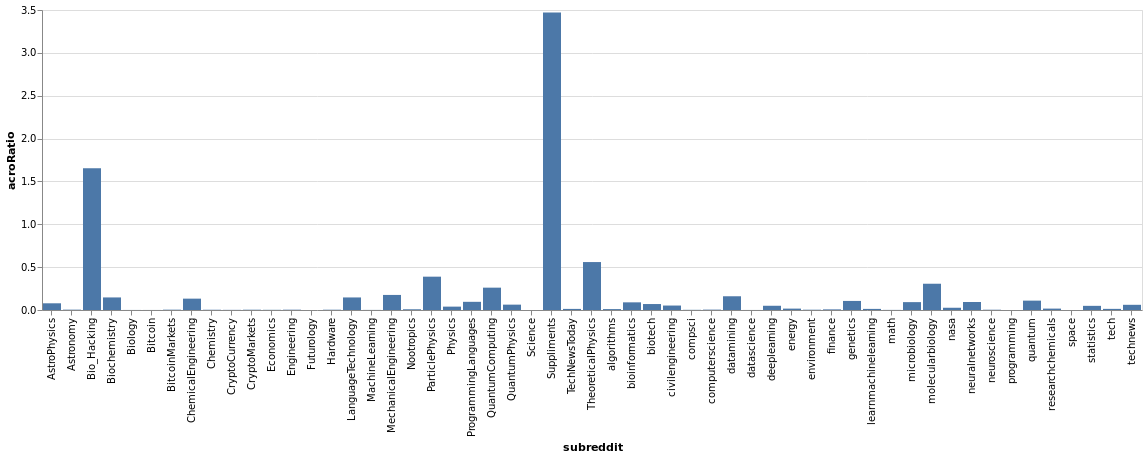

In [73]:
#Now, lets make a derived column and see the chart. Define acroCount/subscribers as a ratio. 
def f(x,y): #assume we dont have y=0!
    return (x/y)
srDF['acroRatio'] = srDF[['acroCount','subscribers']].apply(lambda x: f(*x), axis=1)
srDF.head(5)

#Lets make our altair histogram for this.
alt.Chart(srDF).mark_bar().encode(
x='subreddit',
y='acroRatio')

print("Median=" + str(srDF["subscribers"].median()))

So Suppliments and Bio_Hacking, ParticlePhysics, Theoretical Physics have ratio around 0.5 or way higher. 
These subreddits have comparatively low subscriber counts (below the median for all of them).

Also Note: Last two subreddits have NANs(??)

Lets look at a histogram for one of the subreddits.

In [107]:
#use boolean selections to get our subDF:
nootDF = acroDF[acroDF["subreddit"] == "Engineering"]
nootGps = nootDF.groupby(by="acronym",as_index=False).count().sort_values(by="user",ascending=False)
nootGps.head(20)


,acronym,commID,time,user,subreddit
117,CAD,131,131,131,131
759,RPM,41,41,41,41
397,HVAC,40,40,40,40
829,STEM,38,38,38,38
288,FAA,37,37,37,37
530,MCAS,32,32,32,32
156,CNC,31,31,31,31
255,EDIT,28,28,28,28
427,IMO,26,26,26,26
263,EIT,26,26,26,26


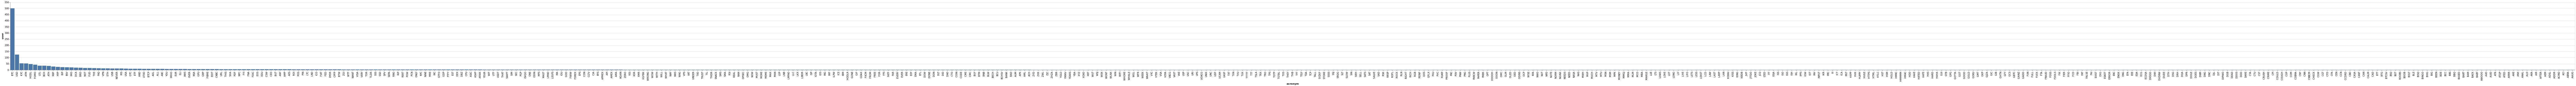

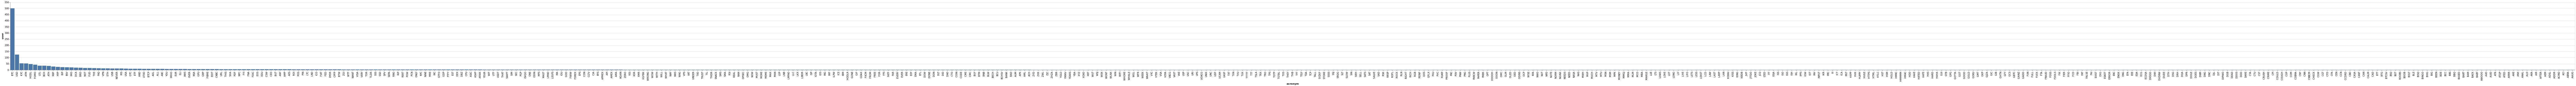

In [98]:
alt.Chart(nootGps).mark_bar().encode(
    alt.X('acronym',sort=alt.EncodingSortField(field="user", order='descending')),
    alt.Y('user:Q'))


What does the distribution of our acronyms look like, over time? I think it is a poisson process (for any acronym to be emitted) over time. Lets take the Nootropics subreddit, and see what we get. For this, we need to extract every entry for this subreddit, and then do grouping/aggregation on each acronym term. We should get a DF of counts.

In [164]:
#Our target data set involves a series of date times (x axis), and indicators 1 or 0 on the y axis. We are looking
#for the spread of the indicator events, basically. We can make a simple dataframe to illustrate this.
#Subreddit and acronym chosen: Engineering, CAD.
tsDF = acroDF[(acroDF["subreddit"] == "Engineering") & (acroDF["acronym"] == "CAD")]
tsDF.drop(['commID','user','acronym','subreddit'],inplace=True, axis=1)
indicatorList = [(1) for x in range(0,131)]
indSeries = pd.Series(indicatorList) #strange that the series failed here, but not in the code above (***)
tsDF["ind"] = indicatorList
tsDF.head(5) #This is a mess. Clean it up! ***

/home/user/Documents/Workspace/CodeProjects/Python3/DSDEenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,time,ind
126118,2019-06-01 01:40:41,1
126129,2019-05-30 20:30:03,1
126199,2019-05-31 11:31:44,1
126335,2019-05-22 11:20:21,1
126373,2019-05-21 01:08:23,1


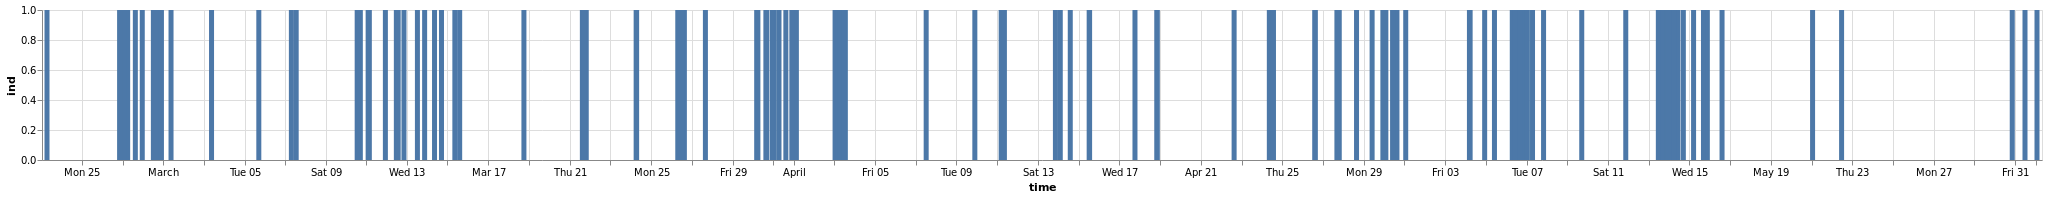

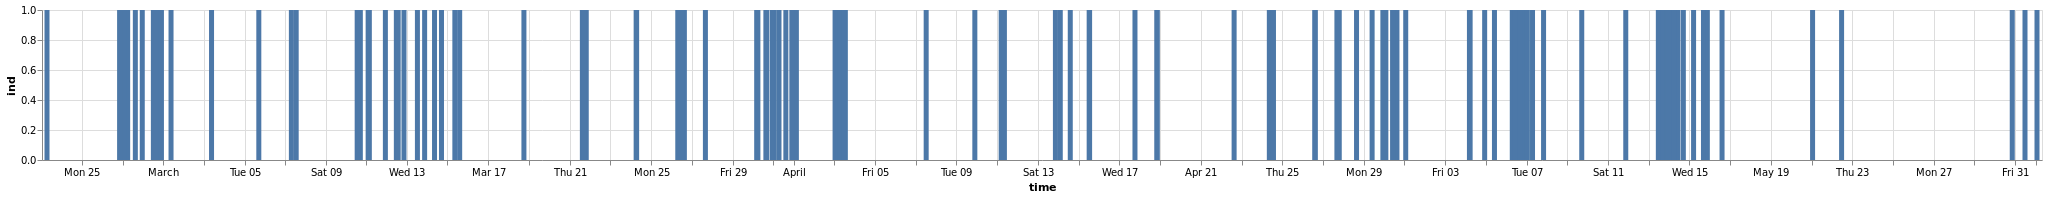

In [165]:
alt.Chart(data=tsDF,height=150,width=2000).mark_bar().encode(
    x='time:T',
    y='ind:Q'
).properties().interactive()


I can see some structure with the .interactive() mode. It looks like a cascading point process...but which one?
Can we assume independence (probably not). This can be the focus of analysis later.

Next, Lets look at the overlap of acronyms across subreddits. Do acronyms live across many subreddits (multi-disciplinary)? How many are just single and stay in one subreddit? What is the ratio of acronyms that are across 5+ 
subreddits? Lets do some group counting and find out. 

In [8]:
acroFocus = acroDF.copy(deep=True) #leave intact for now.
acroFocus.head(5)




,commID,time,user,subreddit,acronym
0,eppv9ry,2019-06-01 08:38:08,arXiv_abstract_bot,MachineLearning,PDF
1,eppqbve,2019-06-01 07:29:08,arXiv_abstract_bot,MachineLearning,KDDC
2,eppsbtw,2019-06-01 07:59:01,tuseroni,MachineLearning,LOOK
3,eppzy33,2019-06-01 09:36:41,farmingvillein,MachineLearning,GPT
4,eppu90m,2019-06-01 08:25:04,tuseroni,MachineLearning,CSS


ValueError: Cannot specify both 'labels' and 'index'/'columns'

In [10]:
acroFocus.drop(['commID','time'], axis=1, inplace=True)
acroFocus.head(5)

,user,subreddit,acronym
0,arXiv_abstract_bot,MachineLearning,PDF
1,arXiv_abstract_bot,MachineLearning,KDDC
2,tuseroni,MachineLearning,LOOK
3,farmingvillein,MachineLearning,GPT
4,tuseroni,MachineLearning,CSS


In [16]:
acroFocusSR = acroFocus[["subreddit","acronym"]]
srGroup = acroFocusSR.groupby(by="acronym",as_index=False).count().sort_values(by="subreddit",ascending=False)
srGroup.head(100)



,acronym,subreddit
1358,BTC,7445
2055,CPU,2332
11763,USD,2157
5413,IMO,1762
7593,NASA,1534
3010,EDIT,1406
4434,GPU,1352
422,AMD,1335
2625,DNA,1218
11747,USA,1116


In [ ]:


.count()
acro2srGroups.reset_index(inplace=True)
acro2srGroups.head(5)
acro2srGroups.get_group("QFT")
#acro2srGroups.iloc[1:100,[1,5]]

In [ ]:
alt.Chart(data=acro2srGroups.iloc[[1:500],[:]],height=500,width=1000).mark_bar().encode(
    x='acronym:N',
    y='subreddit:Q'
).interactive()